In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

okt = Okt()
enc = OneHotEncoder()
tokenizer = Tokenizer()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
best_model_path = './best_model.keras'

vas = pd.read_csv('./vas.csv')

def vas_remap(x):
    if x <= 1:
        return 0
    elif x <= 4:
        return 1
    elif x <= 7:
        return 2
    return 3

vas['vas'] = vas['vas'].apply(vas_remap)

In [145]:
input_array = np.array(vas['vas']).reshape(-1, 1)

enc.fit(input_array)

y_ori = enc.transform(input_array).toarray()

X = []

for sentence in tqdm(vas['symptom']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X.append(stopwords_removed_sentence)

X_train, X_test, y_train, y_test = train_test_split(X, y_ori, random_state=12345, shuffle=True, test_size=.1)

tokenizer.fit_on_texts(X_train)

100%|██████████| 724/724 [00:02<00:00, 299.09it/s] 


In [146]:
type(X_train)

list

In [147]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 323
등장 빈도가 2번 이하인 희귀 단어의 수: 145
단어 집합에서 희귀 단어의 비율: 44.89164086687307
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.74869109947644


In [148]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 179


In [149]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [150]:
# print('최대 길이 :',max(len(review) for review in X_train))
# print('평균 길이 :',sum(map(len, X_train))/len(X_train))
# plt.hist([len(review) for review in X_train], bins=50)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

In [151]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [152]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [154]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [164]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(best_model_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[es, mc])

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.3100 - loss: 1.3664
Epoch 1: val_acc improved from -inf to 0.37405, saving model to ./best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - acc: 0.3128 - loss: 1.3650 - val_acc: 0.3740 - val_loss: 1.2746
Epoch 2/20
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.3966 - loss: 1.2930
Epoch 2: val_acc improved from 0.37405 to 0.63359, saving model to ./best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.3954 - loss: 1.2924 - val_acc: 0.6336 - val_loss: 1.2131
Epoch 3/20
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.4314 - loss: 1.2109
Epoch 3: val_acc did not improve from 0.63359
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.4352 - loss: 1.2087 - val_acc: 0.6260 - val_loss: 1.0533
Epoch 4/20
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.6002 - loss: 1.0417
Epoch 4: val_acc improved from 0.63359 to 0.65649, saving model to ./best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.5998 - 

In [165]:
loaded_model = load_model(best_model_path)
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd5 in position 28: invalid continuation byte -> 경로에 띄어쓰기 등이 있으면 발생하는 에러

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.8260 - loss: 0.3679 

 테스트 정확도: 0.8082


In [166]:
# 토크나이저 백업
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

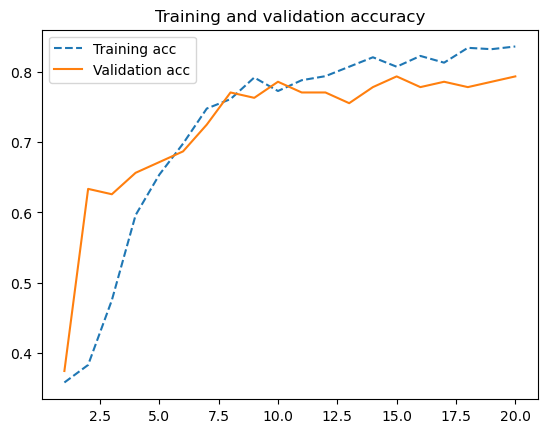

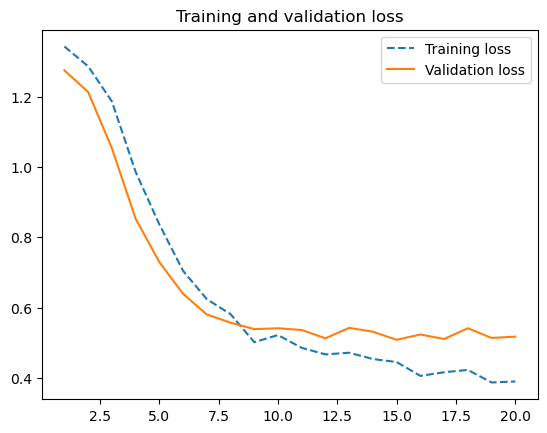

In [167]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '--', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [168]:
vas

,symptom,vas
0,잇몸이 건강하고 통증이 전혀 없어요.,0
1,입안이 아주 깨끗하고 아무런 통증이 없어요.,0
2,치아에 전혀 불편함이 없어요.,0
3,양치할 때 전혀 아프지 않아요.,0
4,음식을 씹을 때 전혀 아프지 않아요.,0
...,...,...
719,치아 통증이 너무 심해서 말하기도 힘들어요.,3
720,가끔 치아가 약간 아플 때가 있어요.,1
721,식사할 때마다 이가 불편하고 아파요.,2
722,치아에 지속적인 중간 정도의 통증이 있어요.,2


In [169]:
new_sentence = '식사할 때마다 이가 불편하고 아파요.'

new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
score = loaded_model.predict(pad_new) # 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [170]:
score

array([[2.4153251e-04, 2.9720095e-01, 7.0183140e-01, 7.2610937e-04]],
      dtype=float32)

In [171]:
np.argmax(score)

2